
# <span style="color:#336699">Image processing on images obtained through STAC</span>
<hr style="border:2px solid #0077b9;">
<div style="text-align: left;">
    <a href="https://nbviewer.org/github/swisstopo/topo-satromo/blob/dev-20241209/codegallery/jupyter/Python/stac/stac-image-processing.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>
<br>
<b>Abstract.</b> This Jupyter Notebook describes how to search for data <em>SwissEO</em> products in data.geo.admin.ch's catalog through the STAC service. Then it shows how to use Python libraries to perform some image processing. It starts by computing the Normalized Difference Vegetation Index (NDVI) based on the red and near-infrared spectral bands. Next, it demonstrates a threshold analysis based on the computed NDVI. Lastly, it computes the VHI difference for images from two diffrent dates.
<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>For an introduction to the SpatioTemporal Asset Catalog (STAC) with the data.geo.admin.ch infrastructure, please, refer to the following Jupyter Notebook:</b>
    <div style="margin-left: 10px; margin-right: 10px">
    <a href="./stac-introduction.ipynb" target="_blank">Introduction to the SpatioTemporal Asset Catalog (STAC)</a>.
    </div>
</div>


# STAC Client API
<hr style="border:1px solid #0077b9;">

For running the examples in this Jupyter Notebook you will need to install the [STAC client for Python](https://github.com/brazil-data-cube/stac.py). To install it from PyPI using `pip`, use the following command:

In [12]:
!pip install pystac-client

In [30]:
!pip install rasterio shapely matplotlib pyproj tqdm

In order to access the funcionalities of the client API, you should import the `pystac_client` package, as follows:

In [14]:
import pystac_client

After that, you can check the installed `pystac_client` package version:

In [15]:
pystac_client.__version__

'0.9.0'

Then, create a `STAC` object attached to the data.geo.admin.ch STAC service:

In [16]:
service = pystac_client.Client.open('https://data.geo.admin.ch/api/stac/v0.9/')

Due to the "Swisstopo finish" STAC implementation,  we need to add the conformance classes: 

In [17]:
service.add_conforms_to("COLLECTIONS")
service.add_conforms_to("ITEM_SEARCH")

# Searching for Sentinel-2 Images
<hr style="border:1px solid #0077b9;">

We are going to use the STAC `search` API to look for images from collection named `ch.swisstopo.swisseo_s2-sr_v100`. This collection is a temporal composite from Sentinel-2/MSI surface reflectance data. Let's define a search box with the following bounds: $x_{min} = 7.364515,$, $x_{max} = 7.535312$, $y_{min} = -46.868545,$, $y_{max} = -46.999127$. Besides that, the period of interest ranges from August 1st, 2018 to July 31st, 2019.

In [18]:
bbox = (7.564515, 46.968545, 7.735312, 47.099127)

In [19]:
item_search = service.search(collections=['ch.swisstopo.swisseo_s2-sr_v100'],
                             bbox=bbox,
                             datetime='2018-08-01/2019-07-31')

In [20]:
items = list(item_search.items())
print(f"Found {len(items)} items")

Found 124 items


Now we want to filter for items, which are at least 20% cloudfree. Since <em>SwissEO</em> is in `EPSG 2056`, we need first to transform th `bbox` accordingly

In [31]:
from pyproj import Transformer

# Create a transformer object
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2056", always_xy=True)

# Transform the coordinates
x_min, y_min = transformer.transform(bbox[0], bbox[1])
x_max, y_max = transformer.transform(bbox[2], bbox[3])

# Create the new bounding box in EPSG:2056
bbox_2056 = (x_min, y_min, x_max, y_max)

No we create a function to test if an item is cloudfree enough. The function with `rasterio` will stream each `mask_10m.tif` file and check the second band if the values in the `bbox_2056` do at least have at least 20% 0 values - cloudfree pixels

In [32]:
import rasterio
import numpy 
def is_cloud_free_enough(item, bbox_2056, threshold=0.2):
    assets = item.assets
    asset_key_mask = next((key for key in assets.keys() if key.endswith('masks-10m.tif')), None)
    
    if asset_key_mask is None:
        return False
    
    with rasterio.open(assets[asset_key_mask].href) as src:
        window = src.window(*bbox_2056)
        cloud = src.read(2, window=window)
        
        # Calculate the percentage of cloud-free pixels (0 values)
        cloud_free_percentage = numpy.sum(cloud == 0) / cloud.size
        
        return cloud_free_percentage >= threshold

Now let's filter  our items with this function, since it will take a while to scan through the plethora of data we will use a progress bar

In [33]:
from tqdm import tqdm
filtered_items = []
for item in tqdm(items, desc="Checking items", unit="item"):
    if is_cloud_free_enough(item, bbox_2056):
        filtered_items.append(item)

print(f"Original number of items: {len(items)}")
print(f"Number of items with at least 20% cloud-free area: {len(filtered_items)}")

Checking items: 100%|██████████| 124/124 [02:16<00:00,  1.10s/item]

Original number of items: 124
Number of items with at least 20% cloud-free area: 34


We have now our mostly cloudfree items in `filtered_items`

# Spectral Indices
<hr style="border:1px solid #0077b9;">

Spectral indices are computed using sensor bands to highlight a certain feature of a target or reduce certain effects. In this context, vegetation indices are spectral indices that enhance characteristics of vegetation, using bands such as Near Infra-red (`NIR`), a region where vegetation shows the most intense reflectance and bands located in red, where the vegetation has the highest absorption of visible sunlight due to the presence in its constitution of the green pigment chlorophyll (Meneses, 2012). The behavior of these spectral bands in some types of targets can be observed below:

<center>
<img src="https://brazil-data-cube.github.io/_images/spectral-profile.png" width="480" />
<br/>
Spectral profile of several targets. Source: modified from Pan et. al (2015).
</center>

# Calculating the Normalized Difference Vegetation Index (NDVI)
<hr style="border:1px solid #0077b9;">

The normalized difference vegetation index (NDVI) is calculated using the **Red** and **Near Infrared** (NIR) spectral bands. It assesses whether or not the target being observed contains live green vegetation. It can be calculated through the following equation:

$$
NDVI = \frac{(NIR - RED)}{(NIR + RED)}
$$

<center><b>Equation 1</b> - NDVI.</center>

We are going to compute the NDVI just with images from the first item:

In [34]:
#items = list(item_search.items())

In [35]:
item = filtered_items[0]
item

<Item id=2019-06-04t103029>

<div style="text-align: justify;  margin-left: 15%; margin-right: 15%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Note:</b> <em>SwissEO</em> already provides the <em>VHI</em> alongside with the spectral bands for the item, besides the quality indicators (<em>MASKS</em>, <em>CLOUD</em>, <em>CLOUDPROBABILITY</em>, <em>CLOUD&TERRAINSHADOW</em>).
</div>

The assets with the links to the images, thumbnails or specific metadata files, can be accessed through the property `assets` (from a given item):

In [36]:
assets = item.assets

The data of the Sentinel-2 10 bands is available under the dictionary key which do end with`bands-10m.tif`:

In [37]:
asset_key_10m = next((key for key in assets.keys() if key.endswith('bands-10m.tif')), None)
band10m_asset = assets[asset_key_10m]


The metadata of the Sentinel-2 10 bands is available under the dictionary key which do end with`metadata.json`:

In [38]:
asset_key_metadata = next((key for key in assets.keys() if key.endswith('metadata.json')), None)
metadata_asset = assets[asset_key_metadata ]
print(metadata_asset.href)

https://data.geo.admin.ch/ch.swisstopo.swisseo_s2-sr_v100/2019-06-04t103029/ch.swisstopo.swisseo_s2-sr_v100_mosaic_2019-06-04t103029_metadata.json


As one can see in the above linked json, the `B04`red wavelength  correspond to the the first band 1 in  'bands-10m.tif' and `B08` near-infrared to the band 4.

Now we retrieve with `rasterio` method the part of an image according to a rectangle specified in `bbox_2056`. We get then `red` and `nir` bands, which we scale back to radiance by factor 10'000:

<div style="text-align: justify;  margin-left: 15%; margin-right: 15%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Note:</b> S2 SR 10m and 20m bands precomputed by swisstopo ranges from <em>-10000</em> to <em>10000</em>,  as can be seen in the item metadata. This is due to the lower volume required to store files that use 16-bit integer values rather than 32-bit float.
</div>

In [39]:
with rasterio.open(assets[asset_key_10m].href) as src:
    window = src.window(*bbox_2056)   
    red = src.read(1, window=window)/10000  
    nir = src.read(4, window=window)/10000  

<div style="text-align: justify;  margin-left: 15%; margin-right: 15%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Note:</b> If there are errors because of your pyproj version, you can run the code below as specified in <a  href="https://rasterio.readthedocs.io/en/latest/faq.html#why-can-t-rasterio-find-proj-db-rasterio-from-pypi-versions-1-2-0" target="_blank">rasterio documentation</a> and try again:

       import os
       del os.environ['PROJ_LIB']
</div>

In [40]:
red

array([[0.0836, 0.0691, 0.0599, ..., 0.0633, 0.0668, 0.0651],
       [0.0481, 0.0413, 0.0417, ..., 0.063 , 0.0659, 0.0647],
       [0.0403, 0.0397, 0.0396, ..., 0.0653, 0.0678, 0.0648],
       ...,
       [0.0396, 0.065 , 0.1006, ..., 0.0297, 0.0256, 0.0265],
       [0.0464, 0.09  , 0.102 , ..., 0.0314, 0.0247, 0.0262],
       [0.0753, 0.1138, 0.1074, ..., 0.0301, 0.0265, 0.0273]],
      shape=(1455, 1294))

In [41]:
nir

array([[0.3602, 0.3735, 0.3932, ..., 0.3433, 0.3414, 0.3394],
       [0.4058, 0.4146, 0.4118, ..., 0.3524, 0.3488, 0.3502],
       [0.4141, 0.4104, 0.4119, ..., 0.3751, 0.3652, 0.3709],
       ...,
       [0.3413, 0.3414, 0.3424, ..., 0.4486, 0.3955, 0.3927],
       [0.3377, 0.3369, 0.3502, ..., 0.4298, 0.3762, 0.4177],
       [0.335 , 0.341 , 0.3548, ..., 0.4111, 0.372 , 0.378 ]],
      shape=(1455, 1294))

Let's take a look at the retrieved data:

In [44]:
from matplotlib import pyplot as plt

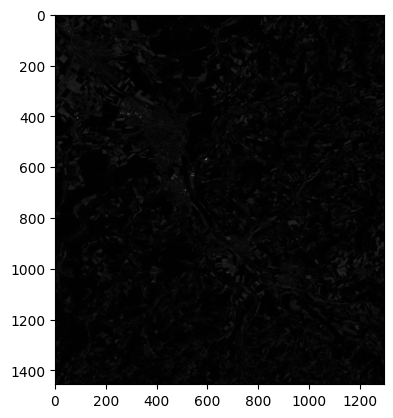

In [45]:
plt.imshow(red, cmap='gray');

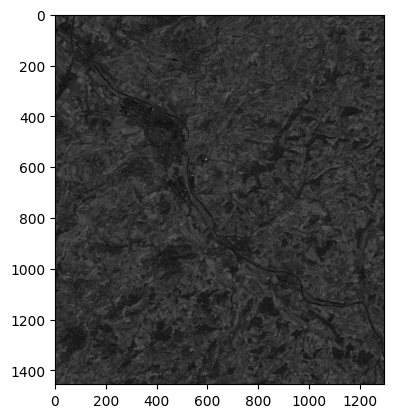

In [46]:
plt.imshow(nir, cmap='gray');

Finally, let's compute the NDVI:

In [47]:
ndvi = (nir - red)/(nir + red)
ndvi

array([[0.62325372, 0.68775418, 0.73559921, ..., 0.68863748, 0.67270946,
        0.67812114],
       [0.78805904, 0.81881992, 0.81609702, ..., 0.6966779 , 0.68217989,
        0.68811762],
       [0.82262324, 0.82359476, 0.82458472, ..., 0.70345141, 0.68683603,
        0.70254762],
       ...,
       [0.79207141, 0.68011811, 0.54582393, ..., 0.87581016, 0.87841368,
        0.8735687 ],
       [0.75839625, 0.57835559, 0.54887218, ..., 0.86383348, 0.87677725,
        0.8819554 ],
       [0.6329515 , 0.49956025, 0.53526612, ..., 0.86355394, 0.86700125,
        0.86528497]], shape=(1455, 1294))

Use the Matplotlib to visualize the result array, we subpress values lowert than 0, since they represent water:

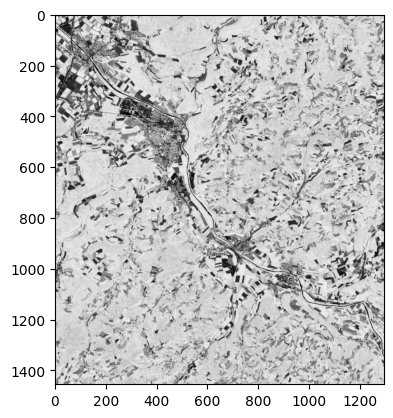

In [48]:
plt.imshow(ndvi, cmap='gray',vmin=0, vmax=1);

We can also plot using other colormaps:

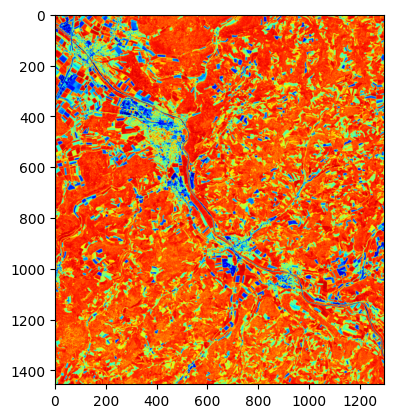

In [49]:
plt.imshow(ndvi, cmap='jet',vmin=0, vmax=1);

For more colormaps check https://matplotlib.org/stable/tutorials/colors/colormaps.html

# Histogram
<hr style="border:1px solid #0077b9;">

The histogram of a digital image, also known as frequency distribution, is the graphic representation in columns showing the intensity of values and the number of pixels with such intensity and is the basis for several types of digital image processing (Gonzalez & Woods, 2007). Some types of histogram can be observed below:

<center>
<img src="https://brazil-data-cube.github.io/_images/histogram.png" width="480" />
<br/>
Four types of images: dark, bright, low contrast and high contrast, and their respective histograms. Source: (Gonzalez & Woods, 2007).
</center>

# Thresholding images
<hr style="border:1px solid #0077b9;">

Digital image Classification is a broad topic and basically consists of assigning labels to targets in a dataset, also called classes. Although many of the classification approaches are complex, there are some simple approaches to solving certain problems, such as thresholding.

The idea of assigning a class following a threshold assumes that the data can be separated by a simple "line", this can be seen in the next figures in a histogram:


<center>
<img src="https://scikit-image.org/docs/dev/_images/sphx_glr_plot_multiotsu_001.png" width="960" />
<br/>
Histogram limiarization example. Source: <a href="https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_multiotsu.html">scikit-image doc</a>
</center>

Let's try to separate our data into groups according to their NDVI values.
But first let's see how the image histogram behaves:

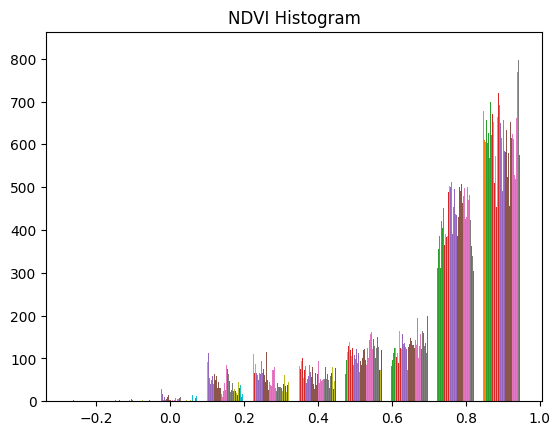

In [50]:
plt.title("NDVI Histogram")
plt.hist(ndvi)
plt.show()

Supposing we can separate the `ndvi` image with threshold, we would assume for this specific case that:
* all pixels with values below 0.2 are dark pixels;
* all pixels above 0.45 are areas containing a good portion of vegetation.
* all pixels with values from 0.2 to 0.45 are areas with few vegetation;

We can perform this thresholding by selecting in the ndvi matrix all values belonging to a given range and assigning a common integer value. We assume the following integer values:
* `1`: dark pixels;
* `2`: vigorous vegetation;
* `3`: weak vegetation.

Let's first create a copy of the original ndvi matrix:

In [51]:
labeled_img = ndvi.copy()

Now, we can use the new copy of the ndvi array and assign the values according to each range of values:

In [52]:
labeled_img[ndvi < 0.2] = 1 # < 0.2
labeled_img[ndvi >= 0.2] = 3 # 0.2 - 0.45
labeled_img[ndvi >= 0.45] = 2 # >= 0.45
labeled_img

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], shape=(1455, 1294))

Finally, let's see the `ndvi` image separated into those labels:

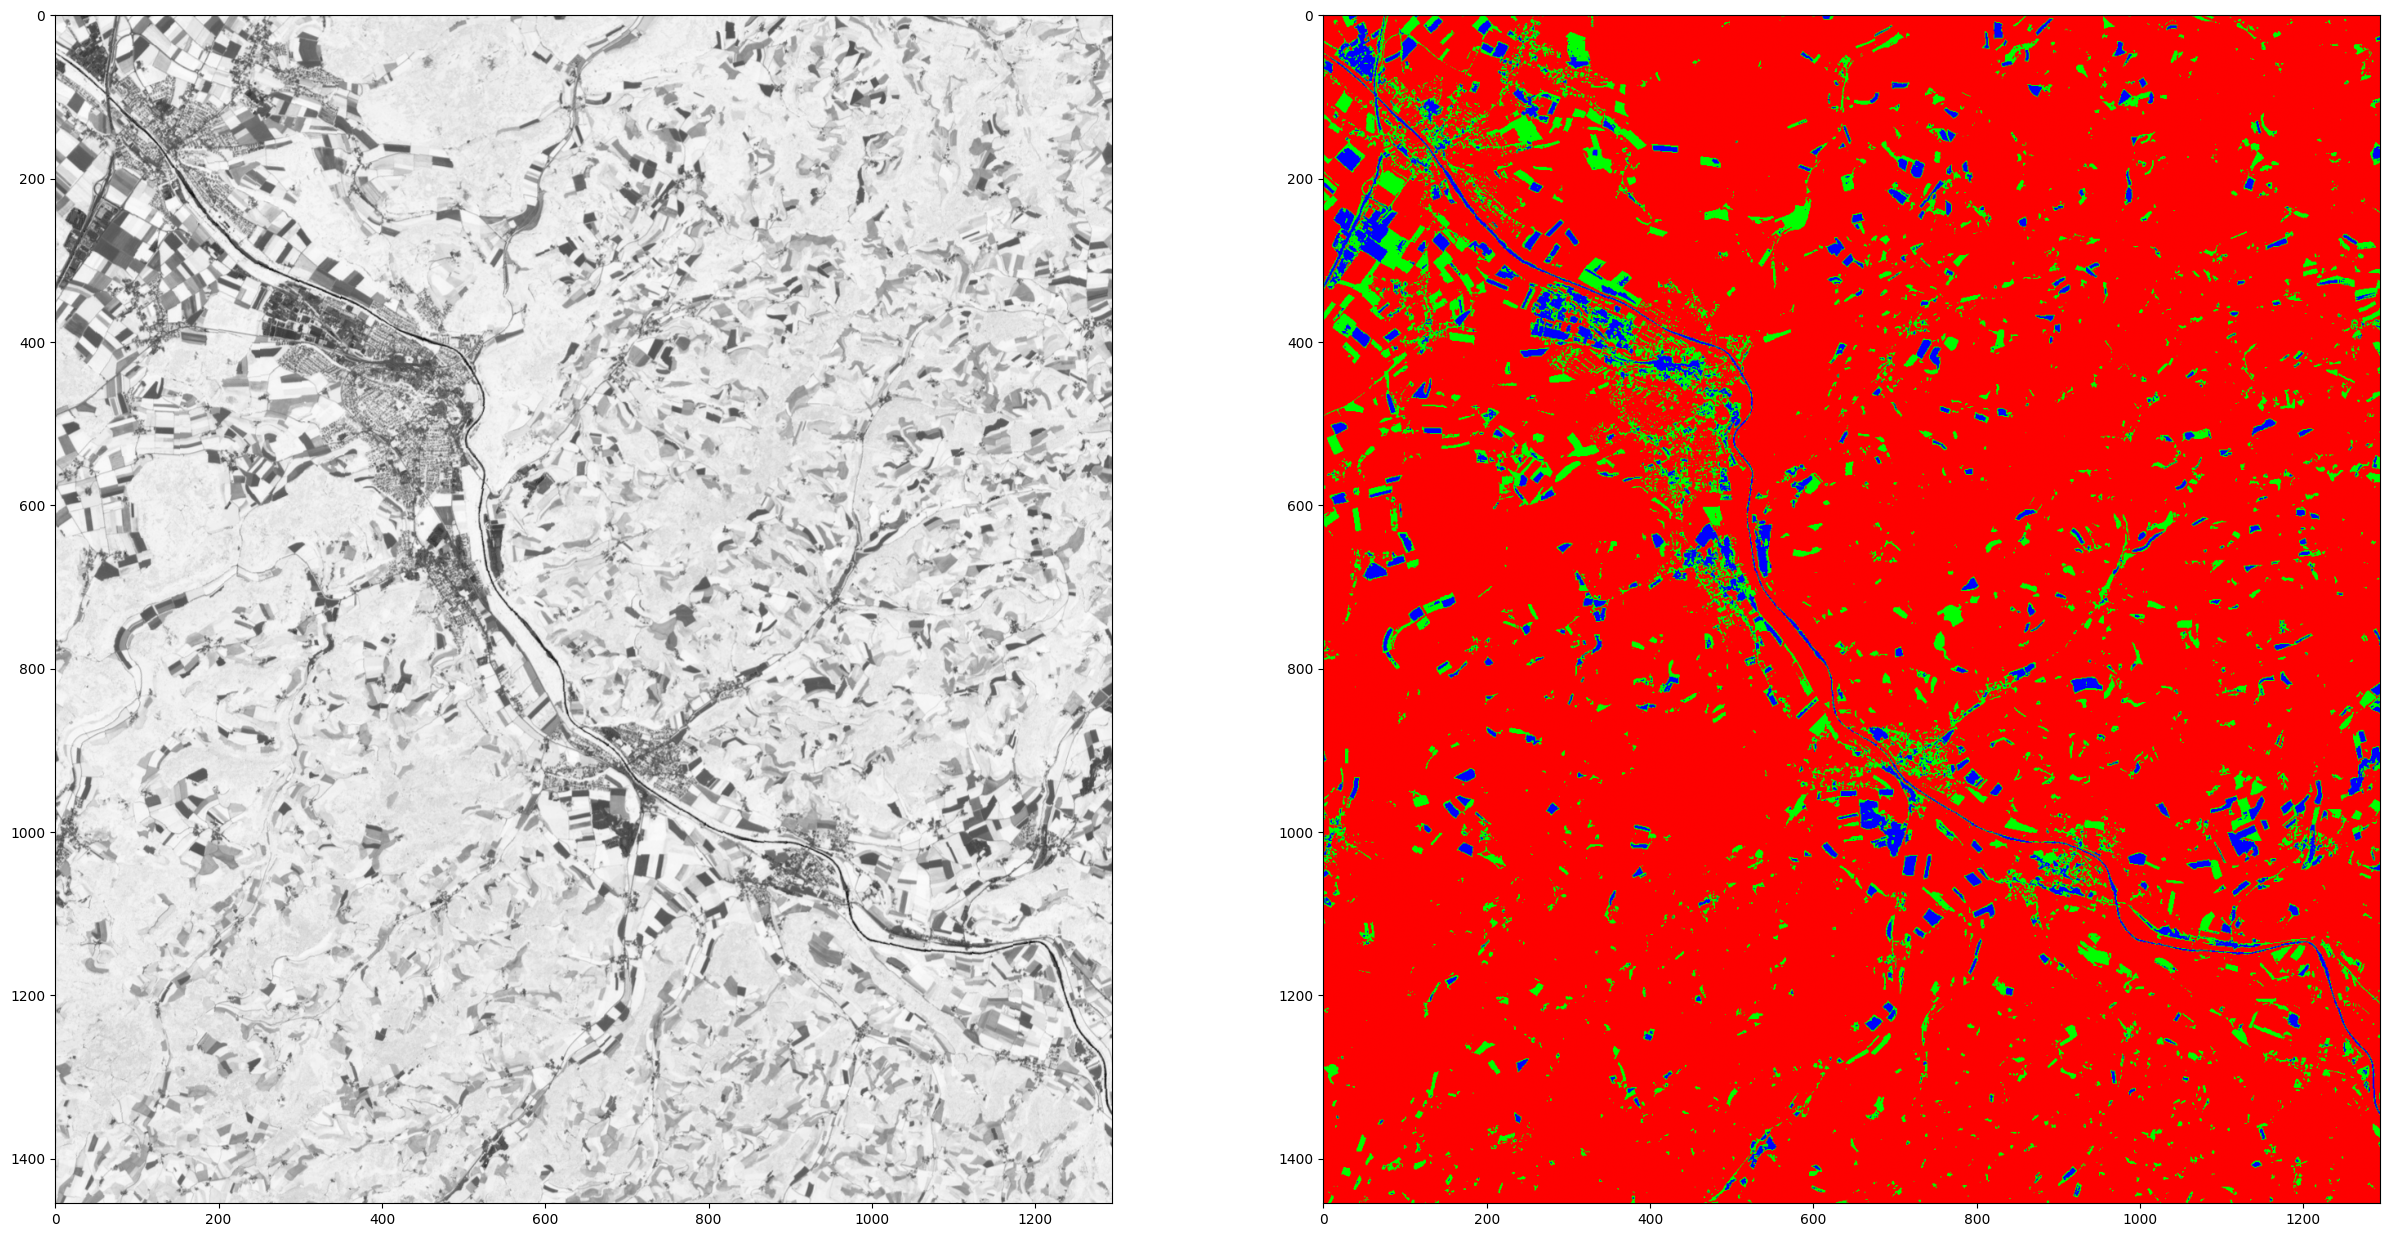

In [53]:
plt.rcParams['figure.figsize'] = [30, 20] #Change plot size
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ndvi, cmap='gray')
ax2.imshow(labeled_img, cmap='brg');

# Calculating Image Difference
<hr style="border:1px solid #0077b9;">

Now let's suppose we want to compare the VHI for images from two different dates and same location, for instance to verify the areas where crops have grown and areas that loss vegetation.

For this computation we are going to use the VHI calculated from <em>SwissEO VHI</em>, and we will select two items (with the same location but with different dates) using direct access to STAC assets. 

The first image comprises pixels from July 29th 2018  (`2018-07-29t235959`), the second one from July 24th 2019 (`2019-07-24`). We know the `COLLECTION`, `ITEM` and `ASSET`, so we can directly access the data with `rasterio`

We define a new `bbox_vhi` in `EPSG 2056`in the Kerzersmoos area:

In [54]:
bbox_vhi=(2575066.36, 1199034.09,2581780.91, 1204371.79 )

Now we retrieve with `rasterio` method the part of July 29th 2018  (`2018-07-29t235959`) according to a rectangle specified in `bbox_vhi`. We get then `vhi_first_image` :

In [55]:
with rasterio.open("https://data.geo.admin.ch/ch.swisstopo.swisseo_vhi_v100/2018-07-29t235959/ch.swisstopo.swisseo_vhi_v100_mosaic_2018-07-29t235959_vegetation-10m.tif") as src:
    window = src.window(*bbox_vhi)   
    vhi_first_image= src.read(1, window=window)
    

Values greater than 100 are no data values, set them accordingly

In [56]:
no_data_value = src.nodata 
vhi_first_image[vhi_first_image > 100] = no_data_value

The 24th 2019 (`2019-07-24`) `vhi_second_image` comprises pixels, approx a year later than the first one selected. 

In [57]:
with rasterio.open("https://data.geo.admin.ch/ch.swisstopo.swisseo_vhi_v100/2019-07-24t235959/ch.swisstopo.swisseo_vhi_v100_mosaic_2019-07-24t235959_vegetation-10m.tif") as src:
    window = src.window(*bbox_vhi)   
    vhi_second_image= src.read(1, window=window)

vhi_second_image[vhi_second_image > 100] = no_data_value

Considering that these images are from a vegetable growing area and that these cash crops are planted at different times of the growing season, it is expected that there will be differences in the VHI values since each field will have a different growing / crop type compared to the other image. The forest area in the lower left is consistent in type and therefore the differences are due to the different state of forest stress. This will cause the VHI band to show darker values in these areas when under stress. Using the `gray` color map, high VHI (healthy vegetation) pixels will be more similar to white, while low VHI (stressed vegetation) pixels will be closer to black.
With this in mind, let's visually compare the two VHI images:

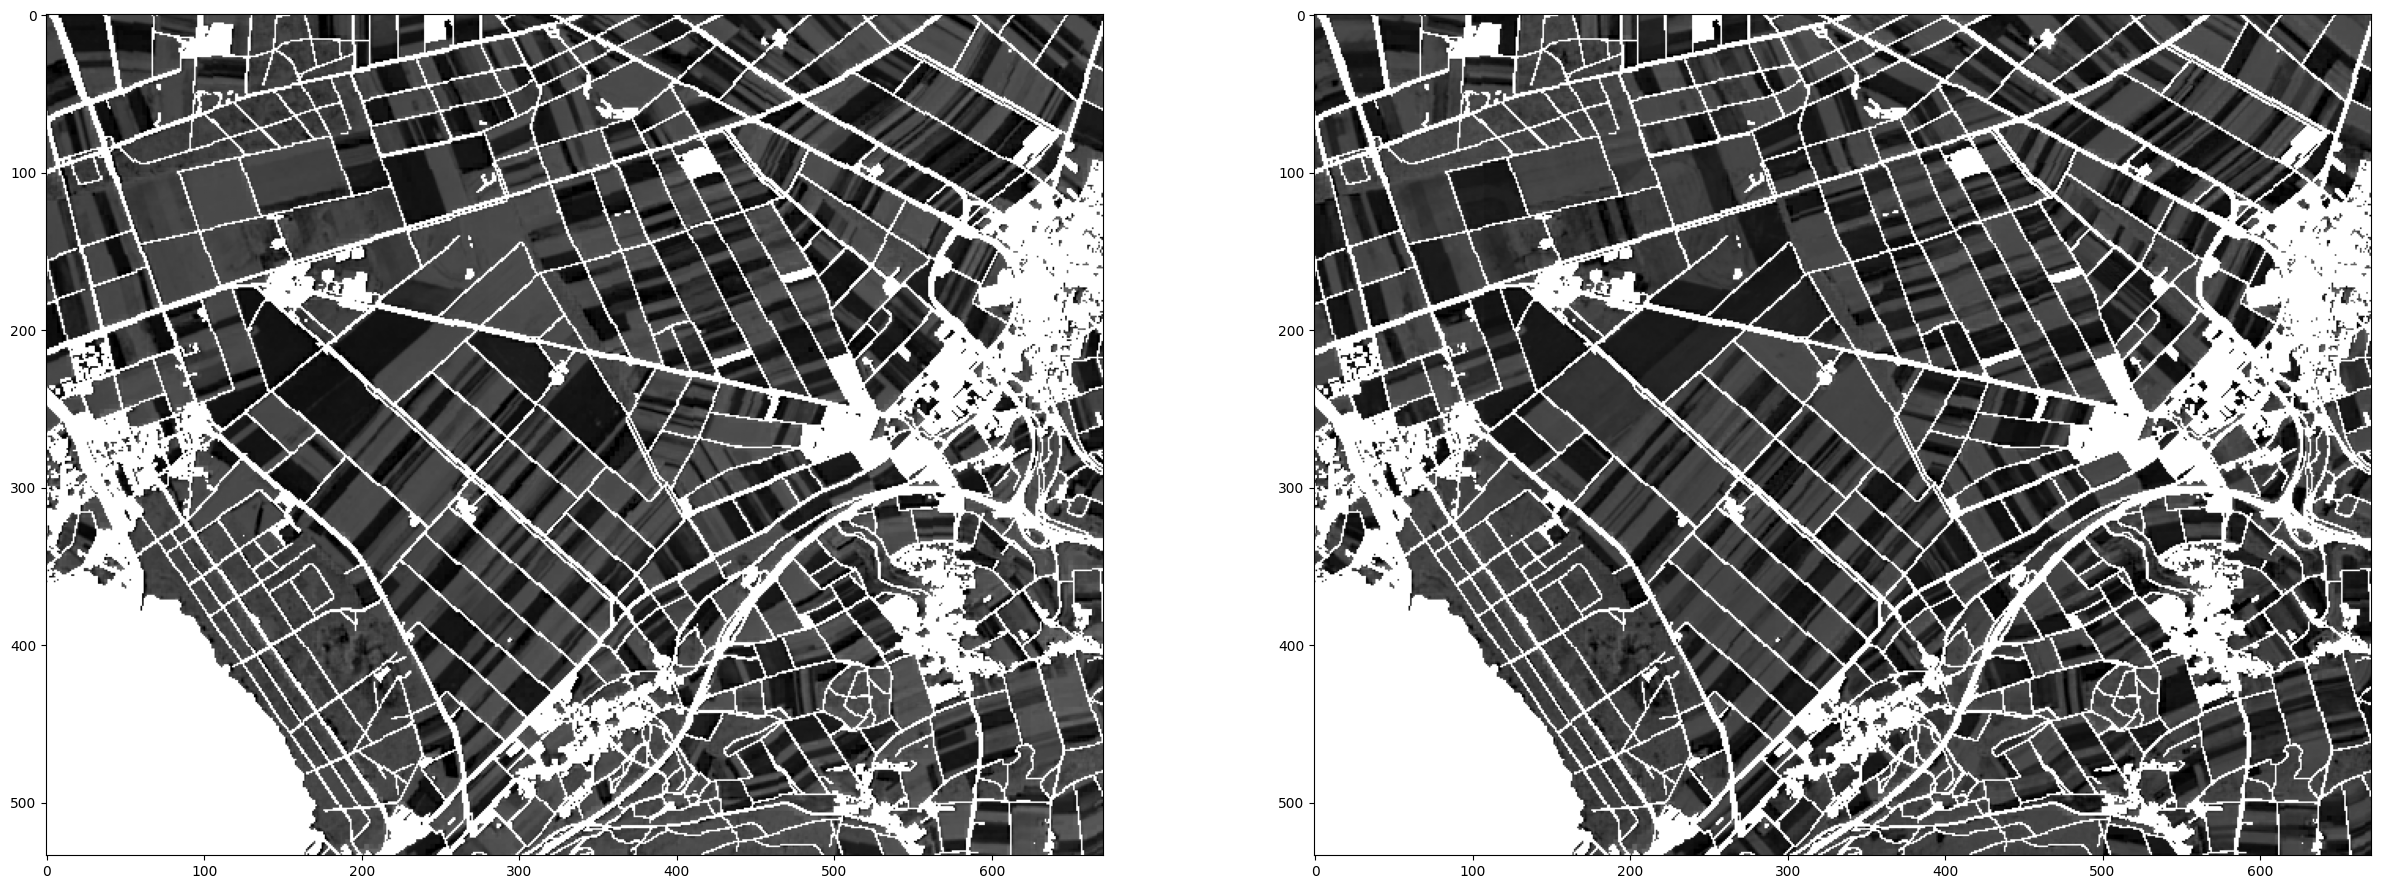

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(vhi_first_image, cmap='gray')
ax2.imshow(vhi_second_image, cmap='gray')

Convert both images to type float32 for subtraction

In [59]:
vhi_first_image = vhi_first_image.astype(numpy.float32)
vhi_second_image = vhi_second_image.astype(numpy.float32)

Create a 16-bit signed array for the result

In [60]:
vhi_diff = numpy.zeros_like(vhi_first_image, dtype=numpy.int16)

Assuming we want to see what have grown and what was loss, let's subtract the 2019 image from the 2018 one and plot it:

In [61]:
vhi_diff = vhi_first_image -vhi_second_image

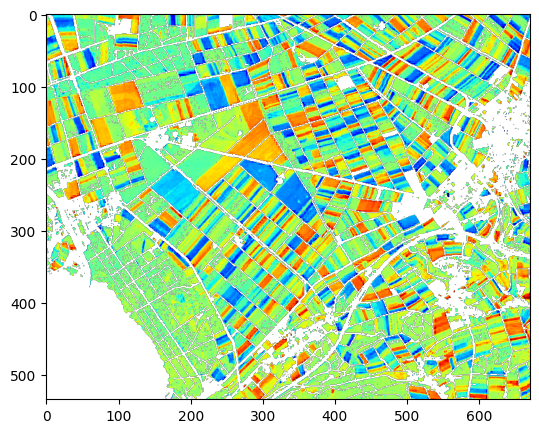

In [62]:
vhi_diff[vhi_diff == 0] = numpy.nan
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(vhi_diff, cmap='jet',vmin=-100,vmax=100);

As illustrated in the VHI difference plot, the most significant alterations in pixel values were observed in agricultural regions, which was anticipated due to shifts in crop cultivation.
The blue values indicate negative values, while the red values are positive. This indicates that for the blue areas, there was a loss of vegetation, as evidenced by a decreasing VHI value, which signifies that crops were harvested. Conversely, in the red areas, the VHI value increased as a result of the more vigorous vegetation observed on the 2019 date.

# References
<hr style="border:1px solid #0077b9;">

- [Python Client Library for STAC Service](https://pystac-client.readthedocs.io/en/latest/)

- [Spatio Temporal Asset Catalog Specification](https://stacspec.org/)

# See also the following Jupyter Notebooks
<hr style="border:1px solid #0077b9;">

* [Introduction to the SpatioTemporal Asset Catalog (STAC)](./stac-introduction.ipynb)

<small><b>Acknowledgments</b>:
This Jupyter Notebook was inspired by the code gallery tutorial from the [Brazil Data Cube Code Gallery](https://github.com/brazil-data-cube/code-gallery/). Special thanks to their open-source contributions and educational resources that helped shape this tutorial.</small>